#HW3 - Regression

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pylab
from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split, cross_validate,GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import MinMaxScaler,PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor


params = {'xtick.labelsize': 10,
 'ytick.labelsize': 10,
 'axes.titlesize' : 10,
 'axes.labelsize' : 10,
 'legend.fontsize': 15,
 'legend.title_fontsize': 15,
 'figure.titlesize': 10
 }
pylab.rcParams.update(params)

## Loading the dataset

In [4]:
dataset = pd.read_csv('HW3_data.csv')
random_state = 2 + 12
train_df, _ = train_test_split(dataset, test_size=0.2, train_size=0.8, random_state=random_state)

In [5]:
from prepare import prepare_data

dataset = prepare_data(train_df,dataset)
train_df, test_df = train_test_split(dataset, test_size=0.2, train_size=0.8, random_state=random_state)

In [6]:
train = train_df.copy()
test = test_df.copy()

## Section 1: Linear regression implementation

In [7]:
train_subset, val_subset = train_test_split(train, test_size=0.2, train_size=0.8, random_state=random_state,shuffle = False)

In [8]:
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np

class LinearRegressor(BaseEstimator, RegressorMixin):
  """
  Custom linear regression model
  """
  def __init__(self, lr: float = 1e-5):
      """
      Initialize an instance of this class.
      ** Do not edit this method **

      :param lr: the SGD learning rate (step size)
      """
      self.lr = lr
      self.batch_size = 32
      self.w = None
      self.b = 0.0

  # Initialize a random weight vector
  def init_solution(self, n_features: int):
      """
      Randomize an initial solution (weight vector)
      ** Do not edit this method **

      :param n_features:
      """
      self.w = np.zeros(n_features)
      self.b = 0.0

  @staticmethod
  def loss(w, b: float, X, y):
      """
      Compute the MSE objective loss.

      :param w: weight vector for linear regression; array of shape (n_features,)
      :param b: bias scalar for linear regression
      :param X: samples for loss computation; array of shape (n_samples, n_features)
      :param y: targets for loss computation; array of shape (n_samples,)
      :return: the linear regression objective loss (float scalar)
      """

      # TODO: complete the loss calculation
      norm_inputs = (X.dot(w) + b - y)
      norm = np.linalg.norm(norm_inputs)
      loss = pow(norm,2) / X.shape[0]

      return loss

  @staticmethod
  def gradient(w, b: float, X, y):
      """
      Compute the (analytical) linear regression objective gradient.

      :param w: weight vector for linear regression; array of shape (n_features,)
      :param b: bias scalar for linear regression
      :param X: samples for loss computation; array of shape (n_samples, n_features)
      :param y: targets for loss computation; array of shape (n_samples,)
      :return: a tuple with (the gradient of the weights, the gradient of the bias)
      """
      # TODO: calculate the analytical gradient w.r.t w and b
      input_vec = X.dot(w) + b - y
      XtrX = np.transpose(X).dot(input_vec)

      sum = np.sum(input_vec)
      scalar =  2 / X.shape[0]

      g_w = scalar * XtrX
      g_b = scalar * sum

      return g_w, g_b

  def fit_with_logs(self, X, y, max_iter: int = 1000, keep_losses: bool = True,
                    X_val  =None, y_val = None):
      """
      Fit the model according to the given training data.

      :param X: training samples; array of shape (n_samples, n_features)
      :param y: training targets; array of shape (n_samples,)
      :param max_iter: number of SGD iterations
      :param keep_losses: should compute the train & val losses during training?
      :param X_val: validation samples to compute the loss for (for logs only)
      :param y_val: validation labels to compute the loss for (for logs only)
      :return: training and validation losses during training
      """
      # Initialize learned parameters
      self.init_solution(X.shape[1])

      train_losses = []
      val_losses = []

      if keep_losses:
          train_losses.append(self.loss(self.w, self.b, X, y))
          val_losses.append(self.loss(self.w, self.b, X_val, y_val))

      # Iterate over batches (SGD)
      for itr in range(0, max_iter):
          start_idx = (itr * self.batch_size) % X.shape[0]
          end_idx = min(X.shape[0], start_idx + self.batch_size)
          batch_X = X[start_idx: end_idx]
          batch_y = y[start_idx: end_idx]

          # TODO: Compute the gradient for the current *batch*
          g_w, g_b = self.gradient(self.w, self.b, batch_X, batch_y)

          # Perform a gradient step
          # TODO: update the learned parameters correctly
          self.w = self.w - self.lr * g_w
          self.b = self.b - self.lr * g_b

          if keep_losses:
              train_losses.append(self.loss(self.w, self.b,  X, y))
              val_losses.append(self.loss(self.w, self.b,  X_val, y_val))

      return train_losses, val_losses

  def fit(self, X, y, max_iter: int = 1000):
      """
      Fit the model according to the given training data.
      ** Do not edit this method **

      :param X: training samples; array of shape (n_samples, n_features)
      :param y: training targets; array of shape (n_samples,)
      :param max_iter: number of SGD iterations
      """
      self.fit_with_logs(X, y, max_iter=max_iter, keep_losses=False)

      return self

  def predict(self, X):
      """
      Regress labels on samples in X.

      :param X: samples for prediction; array of shape (n_samples, n_features)
      :return: Predicted continuous labels for samples in X; array of shape (n_samples,)
      """

      # TODO: Compute
      y_pred = X.dot(self.w) + self.b

      return y_pred

#### Verify Gradients

In [9]:
def numerical_subgradient(w, b, X, y, delta=1e-4):
    w_ = w.copy()
    g_w = np.zeros_like(w_)
    orig_objective = LinearRegressor.loss(w_, b, X, y)
    for i in range(g_w.shape[0]):
        w_[i] += delta
        perturbed_objective = LinearRegressor.loss(w_, b, X, y)
        w_[i] -= delta
        g_w[i] = (perturbed_objective - orig_objective) / delta

    g_b = (LinearRegressor.loss(w_, b + delta, X, y) - orig_objective) / delta
    return g_w, g_b


def compare_gradients(X, y, deltas, C=1, REPEATS=10, figsize=(10, 6)):
    residual_means_w = []
    residual_means_b = []

    for delta in deltas:
        residuals_w = []
        residuals_b = []

        for _ in range(REPEATS):
            # Randomize vectors in which the gradient is computed
            w = np.random.randn(X.shape[1])
            b = np.random.randn(1)

            # Compute the two types of gradients
            analytic_grad_w, analytic_grad_b = LinearRegressor.gradient(w, b, X, y)

            numeric_grad_w, numeric_grad_b = numerical_subgradient(w, b, X, y, delta=delta)

            residual_w = np.linalg.norm(numeric_grad_w - analytic_grad_w)
            residuals_w.append(residual_w)

            residual_b = np.linalg.norm(numeric_grad_b - analytic_grad_b)
            residuals_b.append(residual_b)

        residual_means_w.append(np.mean(residuals_w))
        residual_means_b.append(np.mean(residuals_b))

    fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(16, 8))
    plt.suptitle('Residuals of analytical and numerical gradients',
                 fontsize=22, fontweight="bold")
    axs[0].set_title(r'Residuals of $\nabla_{w}L\left(w,b\right)$')
    axs[1].set_title(r'Residuals of $\frac{\partial}{\partial{b}}L\left(w,b\right)$')
    axs[0].plot(deltas, residual_means_w, linewidth=3)
    axs[1].plot(deltas, residual_means_b, linewidth=3)
    axs[0].set_yscale('log')
    axs[0].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].set_xscale('log')
    axs[0].set_xlabel('$\delta_w$', fontsize=18)
    axs[1].set_xlabel('$\delta_b$', fontsize=18)
    axs[0].set_ylabel(r'$\left\Vert \nabla_{w}L\left(w,b\right) - u_{\delta_w} \left(w,b\right)\right\Vert$',
                      fontsize=18)
    axs[1].set_ylabel(
        r'$\left\Vert \frac{\partial}{\partial{b}}L\left(w,b\right) - u_{\delta_b} \left(w,b\right)\right\Vert$',
        fontsize=18)

    axs[0].grid(alpha=0.5)
    axs[1].grid(alpha=0.5)
    plt.show()


#### Task

In [10]:
X_train = train.drop(columns= 'contamination_level')
y_train = train['contamination_level']

In [11]:
############ Train subset ############
X_train_tmp = train_subset.drop(columns= 'contamination_level')
y_train_tmp = train_subset['contamination_level']

############ Validation subset ############
X_val_tmp = val_subset.drop(columns= 'contamination_level')
y_val_tmp = val_subset['contamination_level']

#### A2

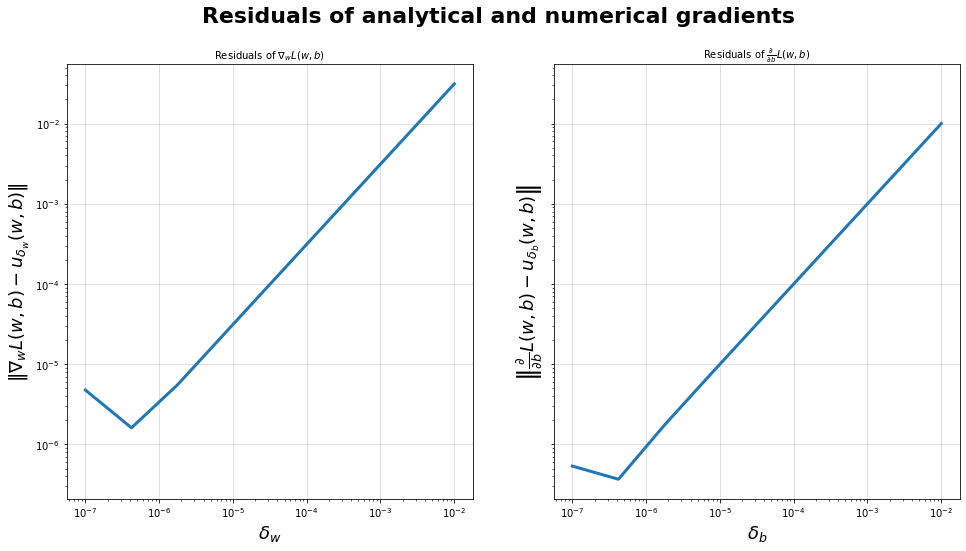

In [12]:
compare_gradients(X_train_tmp, y_train_tmp, deltas=np.logspace(-7, -2, 9))

#### Task

In [13]:
import matplotlib.pyplot as plt
import numpy as np

def test_lr(X_train, y_train, X_val, y_val, title:str, max_iter = 1500):
  lr_list = np.logspace(-9, -1, 9)

  fig, axs = plt.subplots(3, 3, sharey=True, figsize=(20, 12))
  plt.suptitle(title, fontsize=32)
  plt.tight_layout()
  fig.subplots_adjust(hspace=0.5, top=0.9)

  axs = np.ravel(axs)
  for i, lr in enumerate(lr_list):
    cur_linear_reggressor = LinearRegressor(lr)
    train_losses, val_losses = cur_linear_reggressor.fit_with_logs(X_train, y_train, keep_losses=True, X_val=X_val, y_val=y_val, max_iter = max_iter)
    print('lr size = '+str(lr)+', Best train loss = '+str(min(train_losses))+', Best validation loss = '+str(min(val_losses)))

    iterations = np.arange(max_iter + 1)
    axs[i].semilogy(iterations, train_losses, label="Train")
    axs[i].semilogy(iterations, val_losses, label="Validation")
    axs[i].grid(alpha=0.5)
    axs[i].legend()
    axs[i].set_title('lr = '+str(lr))
    axs[i].set_xlabel('iteration')
    axs[i].set_ylabel('MSE')

#### A3

lr size = 9.999999999999999e-10, Best train loss = 399.53201204102123, Best validation loss = 394.85786390010844
lr size = 1e-08, Best train loss = 399.47059738991084, Best validation loss = 394.79851679825157
lr size = 1e-07, Best train loss = 398.85713958206196, Best validation loss = 394.2057215705894
lr size = 1e-06, Best train loss = 392.79091283704366, Best validation loss = 388.3448342380037
lr size = 9.999999999999999e-06, Best train loss = 338.47306239186526, Best validation loss = 335.95648878671403
lr size = 9.999999999999999e-05, Best train loss = 128.99211690796926, Best validation loss = 137.18856632533544
lr size = 0.001, Best train loss = 90.54535783803664, Best validation loss = 103.69742697204818
lr size = 0.01, Best train loss = 84.61670251329559, Best validation loss = 97.07380050070948
lr size = 0.09999999999999999, Best train loss = 84.8599532065346, Best validation loss = 93.65904486980997


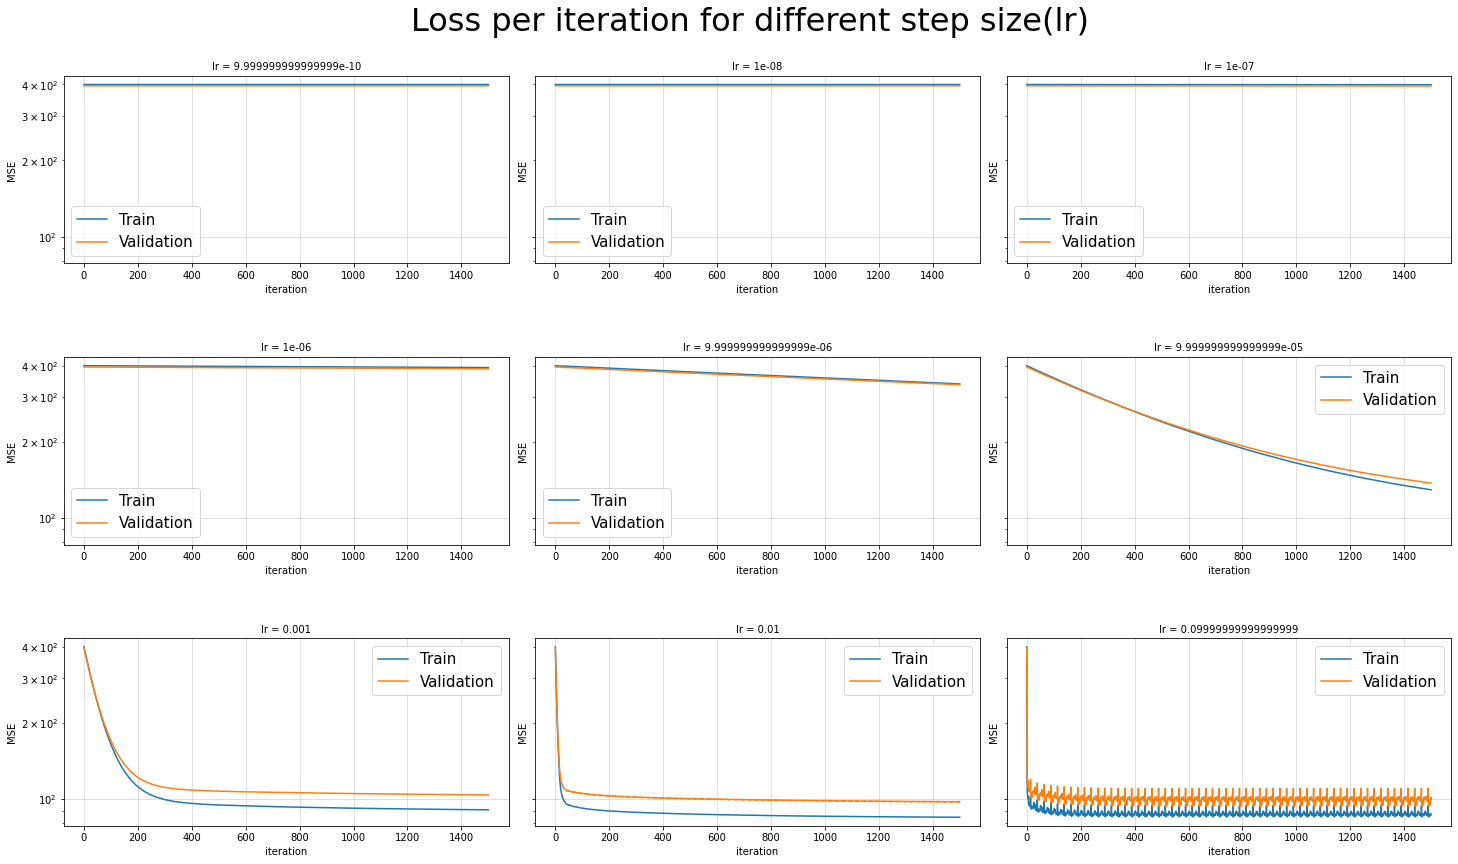

In [14]:
test_lr(X_train_tmp, y_train_tmp, X_val_tmp, y_val_tmp, title="Loss per iteration for different step size(lr)")

## Section 2: Evaluation and Baseline

#### A4

In [15]:
K=5
dummy_clf = DummyRegressor(strategy="mean")
cv_results = cross_validate(estimator=dummy_clf, X=X_train, y=y_train, scoring='neg_mean_squared_error',cv=K,return_train_score=True)
dummy_scores = abs(cv_results['train_score'].mean())
print(f"train MSE score: {-cv_results['train_score'].mean()}")
print(f"Validation MSE score: {-cv_results['test_score'].mean()}")

train MSE score: 99.13589759642296
Validation MSE score: 99.30294981861687


#### Task

In [16]:
dummy_clf.fit(X_train,y_train)

DummyRegressor()

#### A5

Text(0, 0.5, 'MSE')

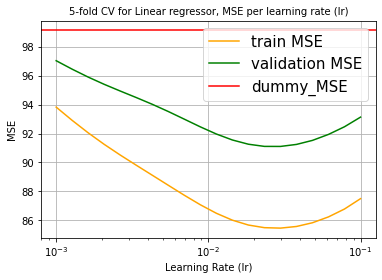

In [17]:
lr_values = np.logspace(-3, -1, 20)
train_scores = []
validation_scores = []

for lr in lr_values:
  linear_reg = LinearRegressor(lr=lr)
  cv_results = cross_validate(estimator=linear_reg, X=X_train, y=y_train, scoring='neg_mean_squared_error',cv=K,return_train_score=True)
  train_scores.append(abs(cv_results['train_score'].mean()))
  validation_scores.append(abs(cv_results['test_score'].mean()))

# plot the results
plt.plot(lr_values,train_scores,c='orange', label='train MSE')
plt.plot(lr_values,validation_scores,c='green', label='validation MSE')
plt.axhline(y=dummy_scores, color='red', label='dummy_MSE')
plt.legend()
plt.grid()
plt.semilogx()
plt.title("5-fold CV for Linear regressor, MSE per learning rate (lr)")
plt.xlabel("Learning Rate (lr)")
plt.ylabel("MSE")



In [18]:
# Get optimal lr according to results

min_validation_index = np.argmin(validation_scores)
min_validation_score = validation_scores[min_validation_index]
min_train_score = train_scores[min_validation_index]
optimal_lr = lr_values[min_validation_index]
print(f"Optimal lr:{optimal_lr}, validation MSE:{min_validation_score}, train MSE:{min_train_score}")

Optimal lr:0.029763514416313176, validation MSE:91.10669937009365, train MSE:85.45293852307223


#### Task

In [19]:
optimal_LinearReg = LinearRegressor(lr=optimal_lr)
optimal_LinearReg.fit(X_train,y_train)

LinearRegressor(lr=0.029763514416313176)

## Section 3: Ridge linear regression

#### A7

Text(0, 0.5, 'MSE')

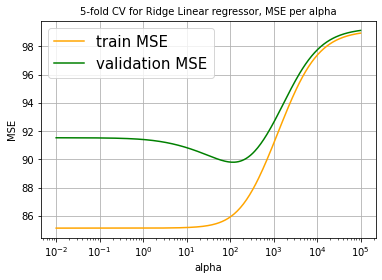

In [20]:
alpha_values = np.logspace(-2, 5, 300)
train_scores = []
validation_scores = []

for alpha in alpha_values:
  ridge_linear_reg = Ridge(alpha=alpha, fit_intercept=True)
  cv_results = cross_validate(estimator=ridge_linear_reg, X=X_train, y=y_train, scoring='neg_mean_squared_error',cv=K,return_train_score=True)
  train_scores.append(abs(cv_results['train_score'].mean()))
  validation_scores.append(abs(cv_results['test_score'].mean()))

# plot the results
plt.plot(alpha_values,train_scores,c='orange', label='train MSE')
plt.plot(alpha_values,validation_scores,c='green', label='validation MSE')
plt.legend()
plt.grid()
plt.semilogx()
plt.title("5-fold CV for Ridge Linear regressor, MSE per alpha")
plt.xlabel("alpha")
plt.ylabel("MSE")

In [21]:
# Get optimal alpha according to results

min_validation_index = np.argmin(validation_scores)
min_validation_score = validation_scores[min_validation_index]
min_train_score = train_scores[min_validation_index]
optimal_alpha = alpha_values[min_validation_index]
print(f"optimal alpha:{optimal_alpha}, validation MSE:{min_validation_score}, train MSE:{min_train_score}")

optimal alpha:118.46187309026824, validation MSE:89.79098483171285, train MSE:86.07993256192681


#### Task

In [22]:
optimal_RidgeLinearRegressor = Ridge(alpha=optimal_alpha, fit_intercept=True)
optimal_RidgeLinearRegressor.fit(X_train,y_train)

Ridge(alpha=118.46187309026824)

#### A9

In [23]:
coefficents_abs = abs(optimal_RidgeLinearRegressor.coef_)
top5_coef_indexes = np.argsort(coefficents_abs)[-5:]
top5_features = X_train.columns[top5_coef_indexes]
print(top5_features)
print(coefficents_abs[top5_coef_indexes])

Index(['happiness_score', 'sport_activity', 'household_income', 'sugar_levels',
       'PCR_01'],
      dtype='object')
[0.60249684 0.60772657 0.6518341  2.36611658 2.49206403]


#### A10

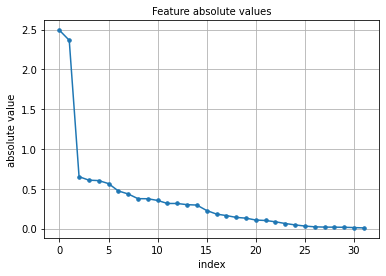

In [24]:
coef_indexes =np.argsort(coefficents_abs)[::-1]
coef_values = coefficents_abs[coef_indexes]

plt.plot(range(len(coefficents_abs)),coef_values, marker=".", markersize=7)
plt.grid()
plt.xlabel('index')
plt.ylabel('absolute value')
plt.title('Feature absolute values')
plt.show()

## Section 4: Polynomial fitting (visualization)

#### Task

In [25]:
X_train_Sec4 = train[['PCR_01','PCR_05']]

#### A14

In [26]:
def plot3d(df, colX:str, colY:str, colZ:str, title:str, predictions=None):
  fig = plt.figure(figsize=(20, 7))
  axes = [fig.add_subplot(1, 3, i+1, projection='3d') for i in range(3)]

  palette = sns.color_palette("hls", 2)

  for i,ax in enumerate(axes):
    if predictions is not None:
      ax.scatter3D(df[colX], df[colY], predictions, color=palette[1], s=3)
      ax.scatter3D(df[colX], df[colY], df[colZ], color=palette[0], s=1,
                   alpha=0.35, depthshade=False)
    else:
      ax.scatter3D(df[colX], df[colY], df[colZ], color=palette[0], s=1)

    ax.set_xlabel(colX)
    ax.set_ylabel(colY)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])

    ax.view_init(elev=5., azim=45*i)

  axes[0].set_zlabel("\n" + colZ, linespacing=2.2)

  plt.suptitle(title, fontsize=32)
  plt.tight_layout()
  plt.show()

/tmp/ipykernel_1394/1706415936.py:25: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


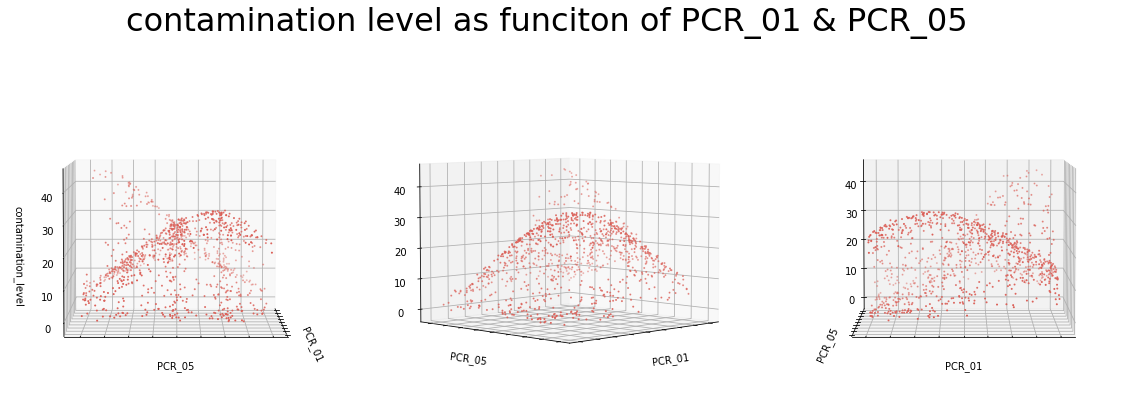

In [27]:
plot3d(train,'PCR_01','PCR_05','contamination_level', 'contamination level as funciton of PCR_01 & PCR_05')

#### A15

Text(0, 0.5, 'MSE')

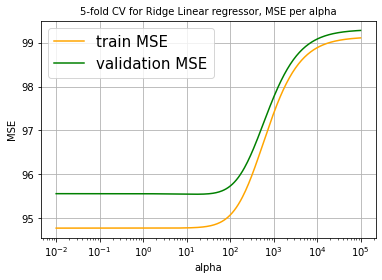

In [28]:
alpha_values = np.logspace(-2, 5, 300)
train_scores = []
validation_scores = []

for alpha in alpha_values:
  ridge_linear_reg = Ridge(alpha=alpha, fit_intercept=True)
  cv_results = cross_validate(estimator=ridge_linear_reg, X=X_train_Sec4, y=y_train, scoring='neg_mean_squared_error',cv=K,return_train_score=True)
  train_scores.append(abs(cv_results['train_score'].mean()))
  validation_scores.append(abs(cv_results['test_score'].mean()))

# plot the results
plt.plot(alpha_values,train_scores,c='orange', label='train MSE')
plt.plot(alpha_values,validation_scores,c='green', label='validation MSE')
plt.legend()
plt.grid()
plt.semilogx()
plt.title("5-fold CV for Ridge Linear regressor, MSE per alpha")
plt.xlabel("alpha")
plt.ylabel("MSE")

In [29]:
min_validation_index = np.argmin(validation_scores)
min_validation_score = validation_scores[min_validation_index]
min_train_score = train_scores[min_validation_index]
optimal_alpha = alpha_values[min_validation_index]
print(f"optimal alpha:{optimal_alpha}, validation MSE:{min_validation_score}, train MSE:{min_train_score}")

optimal alpha:16.11973357388157, validation MSE:95.54367423940069, train MSE:94.7830886812292


#### Task

In [30]:
optimal_RidgeLinearRegressor_Sec4 = Ridge(alpha=optimal_alpha, fit_intercept=True)
optimal_RidgeLinearRegressor_Sec4.fit(X_train_Sec4,y_train)


Ridge(alpha=16.11973357388157)

#### A16

/tmp/ipykernel_1394/1706415936.py:25: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


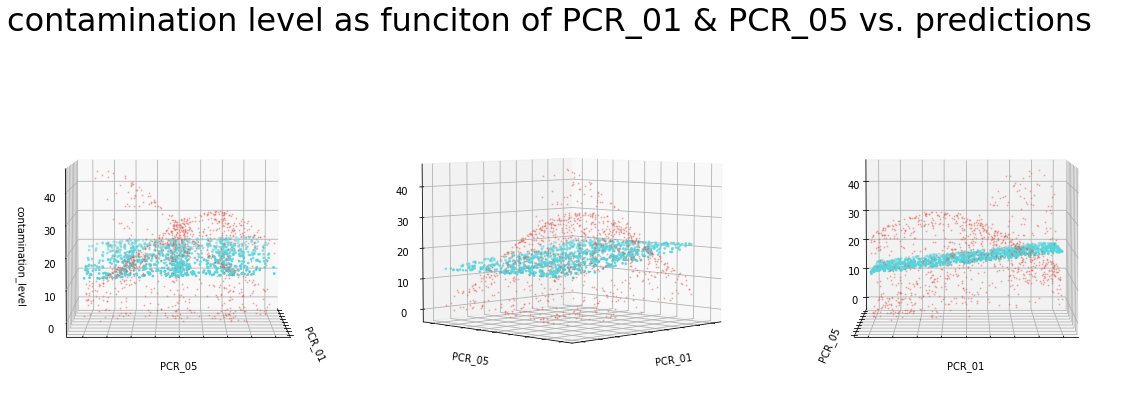

In [31]:
predictions = optimal_RidgeLinearRegressor_Sec4.predict(X_train_Sec4)
plot3d(train,'PCR_01','PCR_05','contamination_level', 'contamination level as funciton of PCR_01 & PCR_05 vs. predictions',predictions=predictions)

#### A18

Text(0, 0.5, 'MSE')

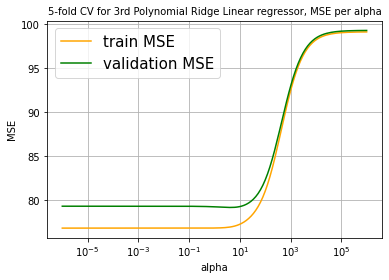

In [32]:
alpha_values = np.logspace(-6, 6, 130)
train_scores = []
validation_scores = []

K=5
deg=3
for alpha in alpha_values:
  poly_reg = Pipeline([('feature_mapping', PolynomialFeatures(degree=deg)),
  ('normalization', MinMaxScaler((-1,1))),
  ('Ridge', Ridge(alpha=alpha, fit_intercept=True))])
  cv_results = cross_validate(estimator=poly_reg, X=X_train_Sec4, y=y_train, scoring='neg_mean_squared_error',cv=K,return_train_score=True)
  train_scores.append(abs(cv_results['train_score'].mean()))
  validation_scores.append(abs(cv_results['test_score'].mean()))

# plot the results
plt.plot(alpha_values,train_scores,c='orange', label='train MSE')
plt.plot(alpha_values,validation_scores,c='green', label='validation MSE')
plt.legend()
plt.grid()
plt.semilogx()
plt.title("5-fold CV for 3rd Polynomial Ridge Linear regressor, MSE per alpha")
plt.xlabel("alpha")
plt.ylabel("MSE")

In [33]:
min_validation_index = np.argmin(validation_scores)
min_validation_score = validation_scores[min_validation_index]
min_train_score = train_scores[min_validation_index]
optimal_alpha = alpha_values[min_validation_index]
print(f"optimal alpha:{optimal_alpha}, validation MSE:{min_validation_score}, train MSE:{min_train_score}")

optimal alpha:4.023936908624901, validation MSE:79.14258379146146, train MSE:76.90894053271911


#### Task

In [34]:
optimal_poly_reg = Pipeline([('feature_mapping', PolynomialFeatures(degree=deg)),
  ('normalization', MinMaxScaler((-1,1))),
  ('Ridge', Ridge(alpha=optimal_alpha, fit_intercept=True))])

optimal_poly_reg.fit(X_train_Sec4,y_train)

Pipeline(steps=[('feature_mapping', PolynomialFeatures(degree=3)),
                ('normalization', MinMaxScaler(feature_range=(-1, 1))),
                ('Ridge', Ridge(alpha=4.023936908624901))])

#### A19

/tmp/ipykernel_1394/1706415936.py:25: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


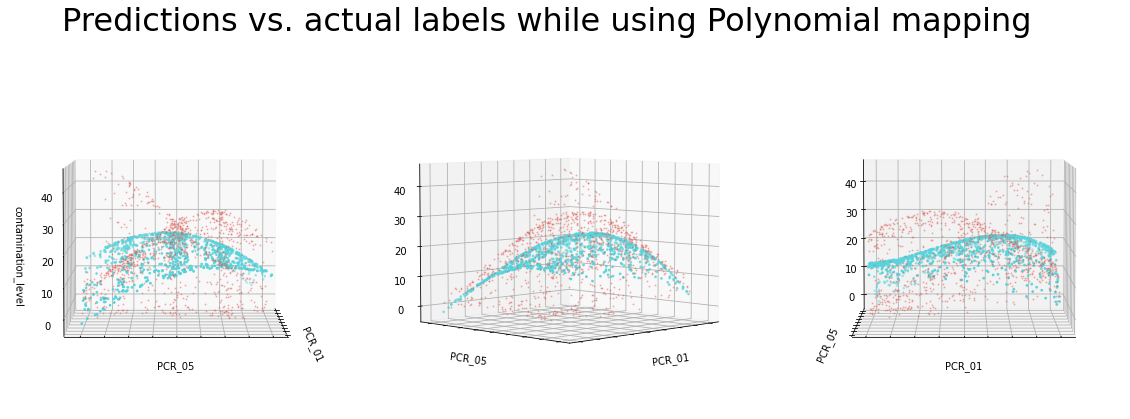

In [35]:
predictions = optimal_poly_reg.predict(X_train_Sec4)
plot3d(train,'PCR_01','PCR_05','contamination_level', 'Predictions vs. actual labels while using Polynomial mapping',predictions=predictions)


## Section 5: Fitting Gradient Boosted Machines (GBM)

#### Task

In [36]:
X_train_Sec_5 = train[['PCR_01','PCR_02','PCR_03','PCR_04','PCR_05','PCR_09','PCR_10','sugar_levels','sport_activity']]
gbr = GradientBoostingRegressor(random_state=0)
gbr.fit(X_train_Sec_5,y_train)

GradientBoostingRegressor(random_state=0)

#### A23

In [37]:
FOLDS = 5
loss_values = ['squared_error', 'absolute_error', 'huber', 'quantile']
lr_values = [10 ** i for i in range(-6, 1)]
subsample_values = [round(x, 1) for x in np.arange(0.1,1.1,0.1)]
min_samples_leaf_values = np.arange(1,11,1)

parameters = {'loss':loss_values,'learning_rate':lr_values,'subsample':subsample_values,'min_samples_leaf':min_samples_leaf_values}
gbr_gscv = GradientBoostingRegressor(random_state=0)
gscv = GridSearchCV(estimator=gbr_gscv,param_grid=parameters,cv=FOLDS,scoring='neg_mean_squared_error', return_train_score=True)
gscv.fit(X_train_Sec_5,y_train)

best_val = abs(gscv.cv_results_["mean_test_score"][gscv.best_index_])
best_train = abs(gscv.cv_results_["mean_train_score"][gscv.best_index_])
print(f"Best parameters: {gscv.best_params_}")
print(f"Best validation Score: {abs(gscv.best_score_)}")
print(f"Best validation Score (Confirm): {best_val}")
print(f"Best train Score: {best_train}")

Best parameters: {'learning_rate': 0.1, 'loss': 'huber', 'min_samples_leaf': 2, 'subsample': 0.6}
Best validation Score: 3.5724674673124204
Best validation Score (Confirm): 3.5724674673124204
Best train Score: 2.0418323726957732


Const params: {'loss': 'huber', 'learning_rate': 0.1, 'random_state': 0}
iterable_paramse: {'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])}


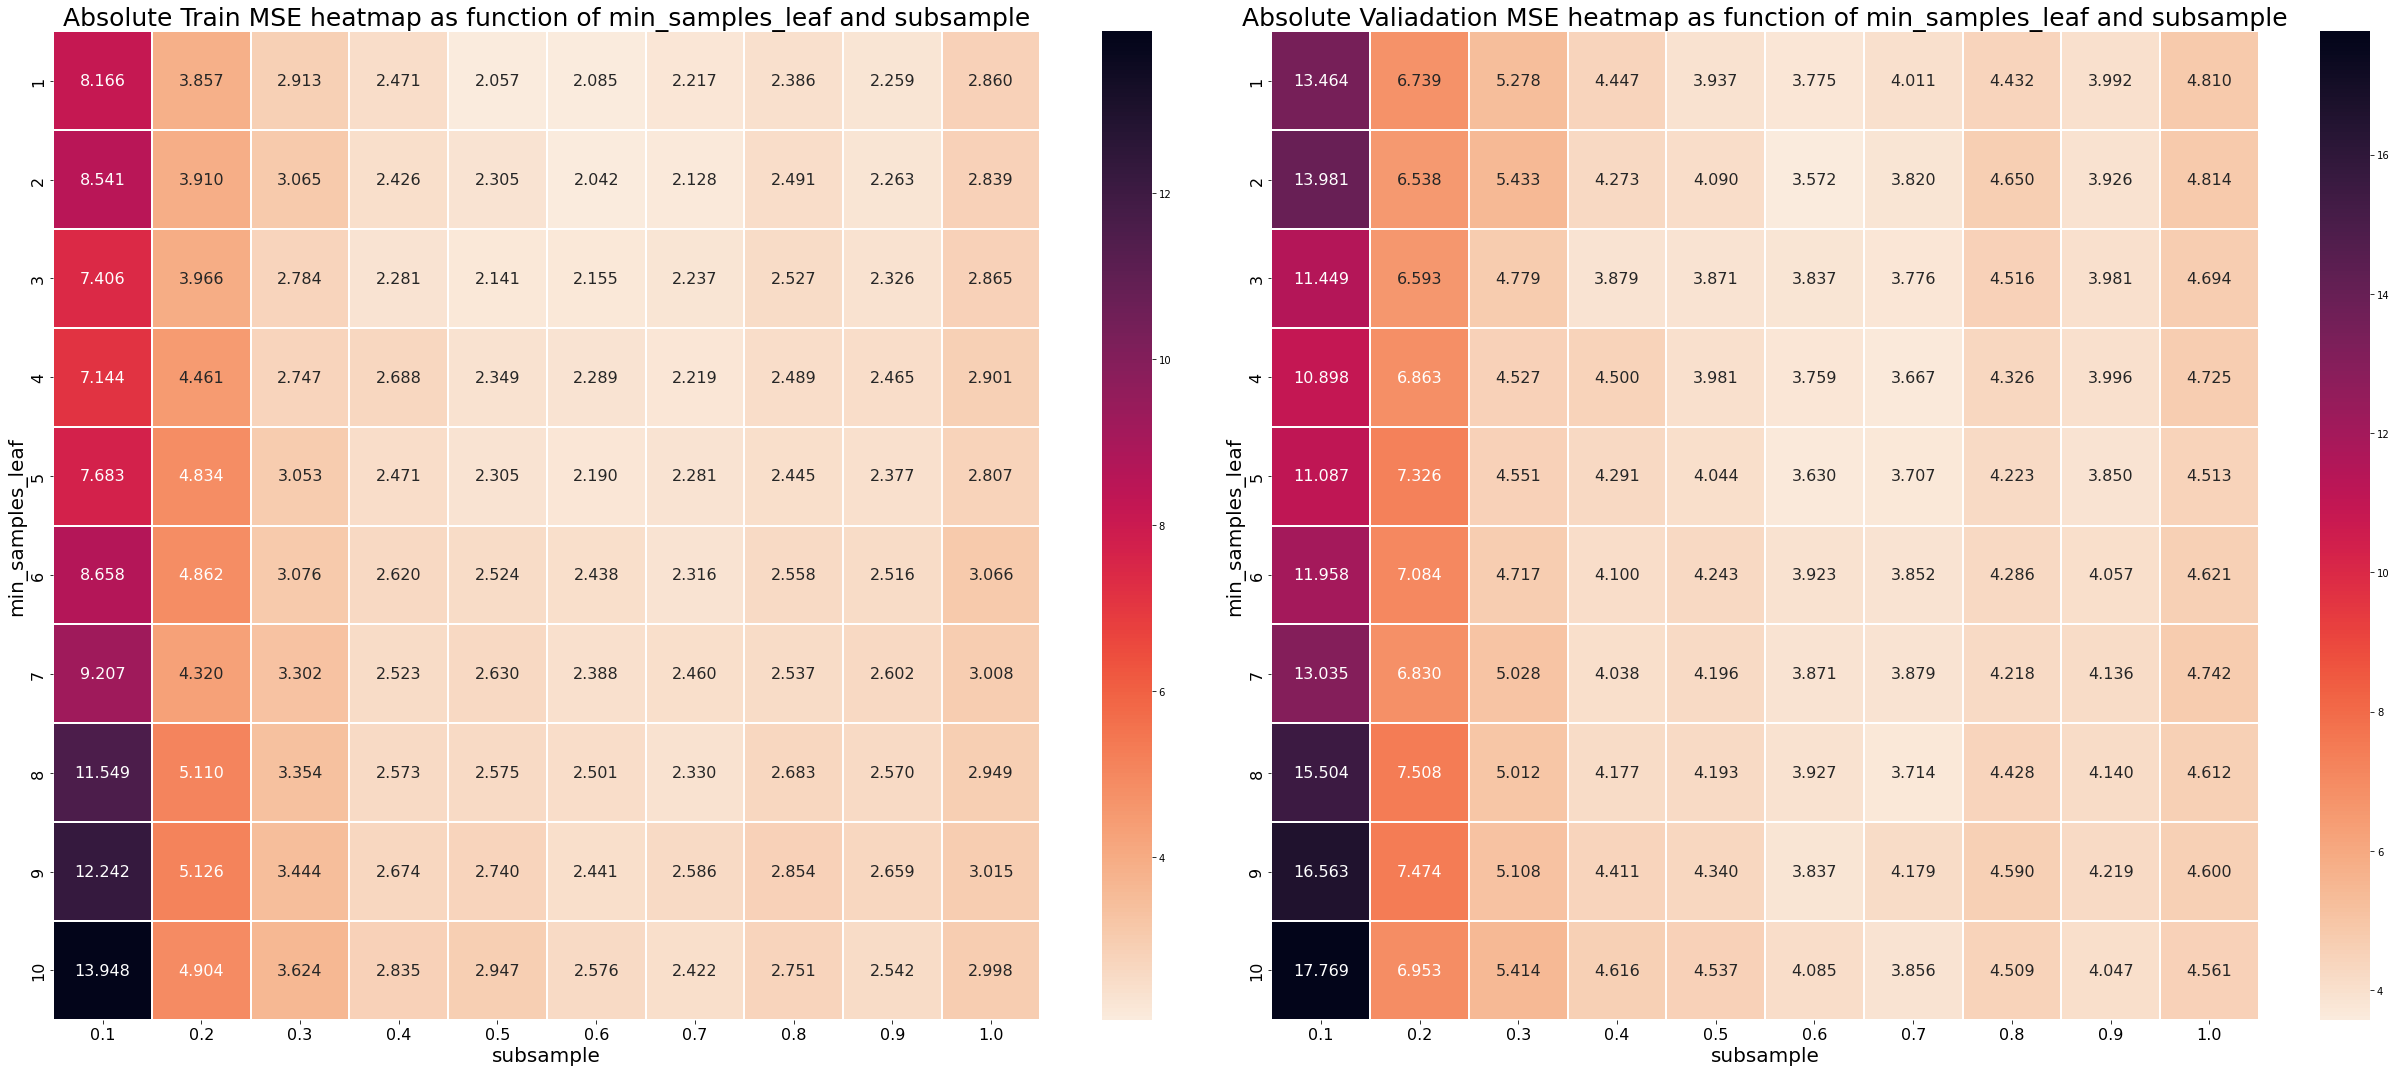

Best params: {'min_samples_leaf': 2, 'subsample': 0.6}
Best validation score: 3.5724674673124204
Best validation score (confirm): 3.5724674673124204
Best train score: 2.0418323726957732


Const params: {'loss': 'huber', 'subsample': 0.6, 'random_state': 0}
iterable_paramse: {'learning_rate': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1], 'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])}


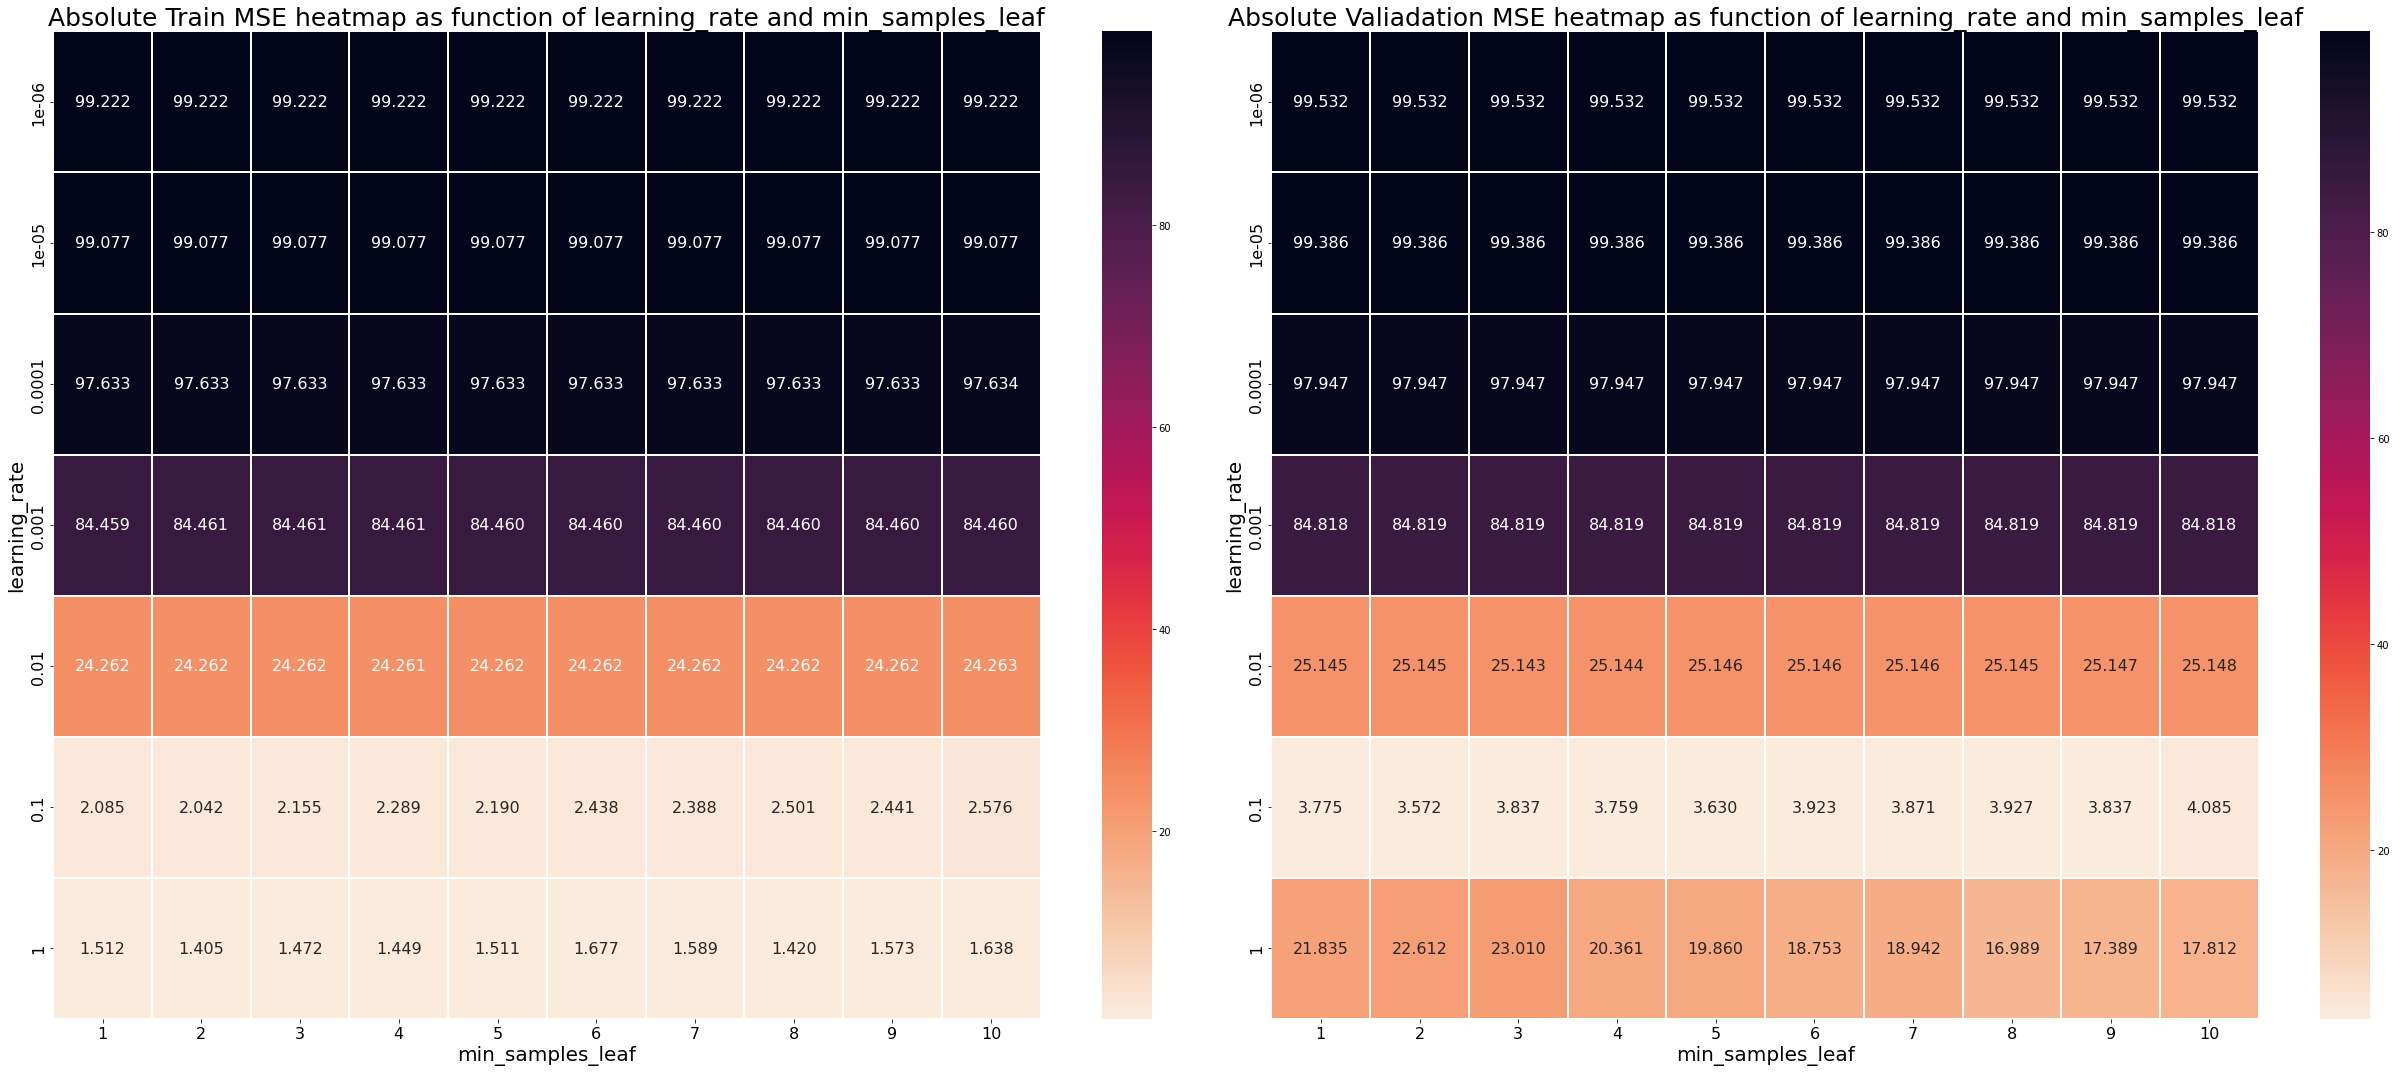

Best params: {'learning_rate': 0.1, 'min_samples_leaf': 2}
Best validation score: 3.5724674673124204
Best validation score (confirm): 3.5724674673124204
Best train score: 2.0418323726957732


Const params: {'loss': 'huber', 'min_samples_leaf': 2, 'random_state': 0}
iterable_paramse: {'learning_rate': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1], 'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}


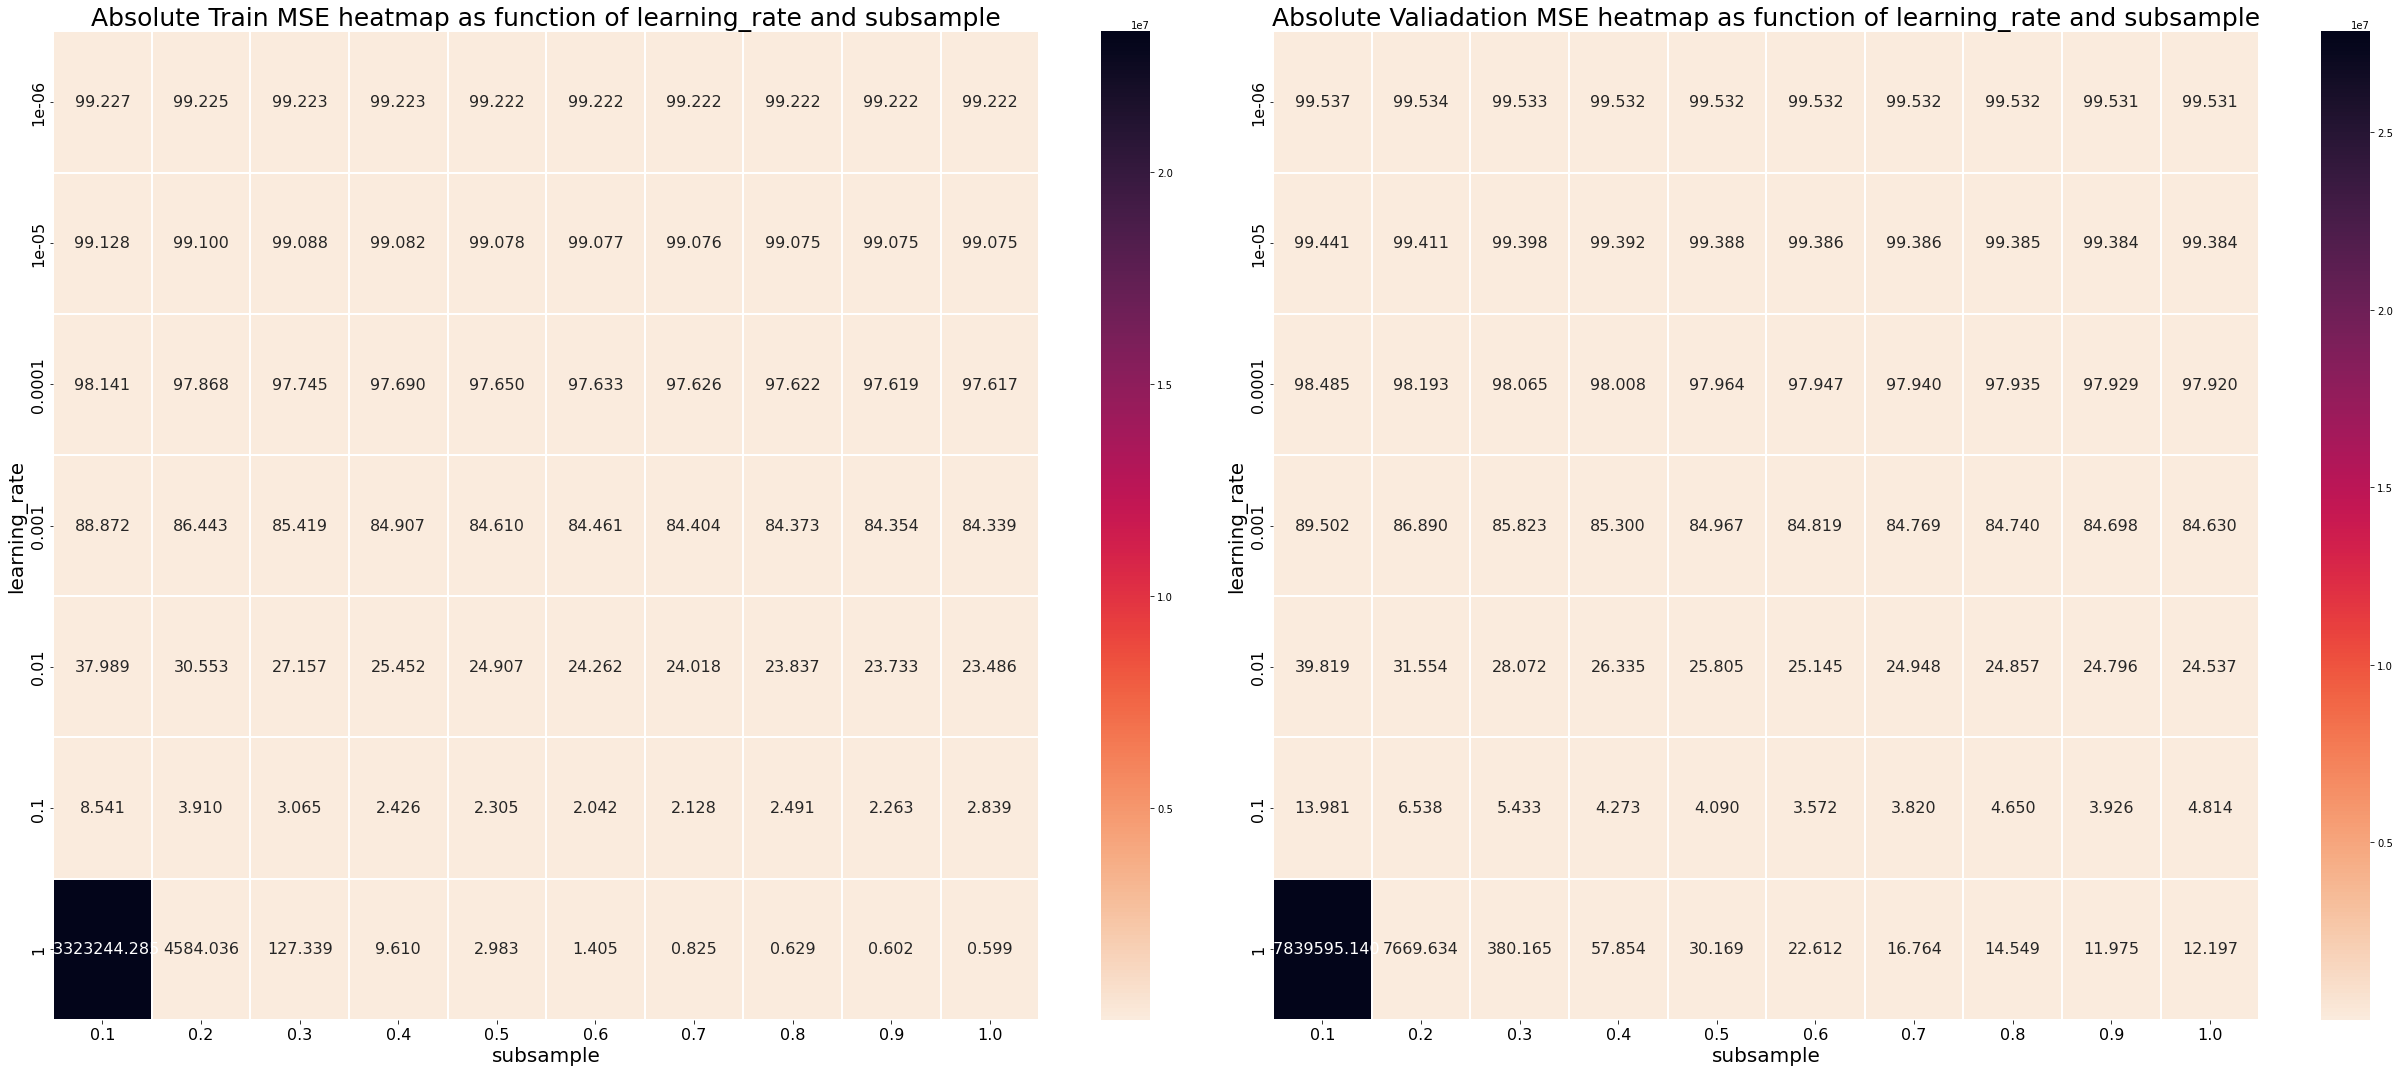

Best params: {'learning_rate': 0.1, 'subsample': 0.6}
Best validation score: 3.5724674673124204
Best validation score (confirm): 3.5724674673124204
Best train score: 2.0418323726957732


Const params: {'learning_rate': 0.1, 'subsample': 0.6, 'random_state': 0}
iterable_paramse: {'loss': ['squared_error', 'absolute_error', 'huber', 'quantile'], 'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])}


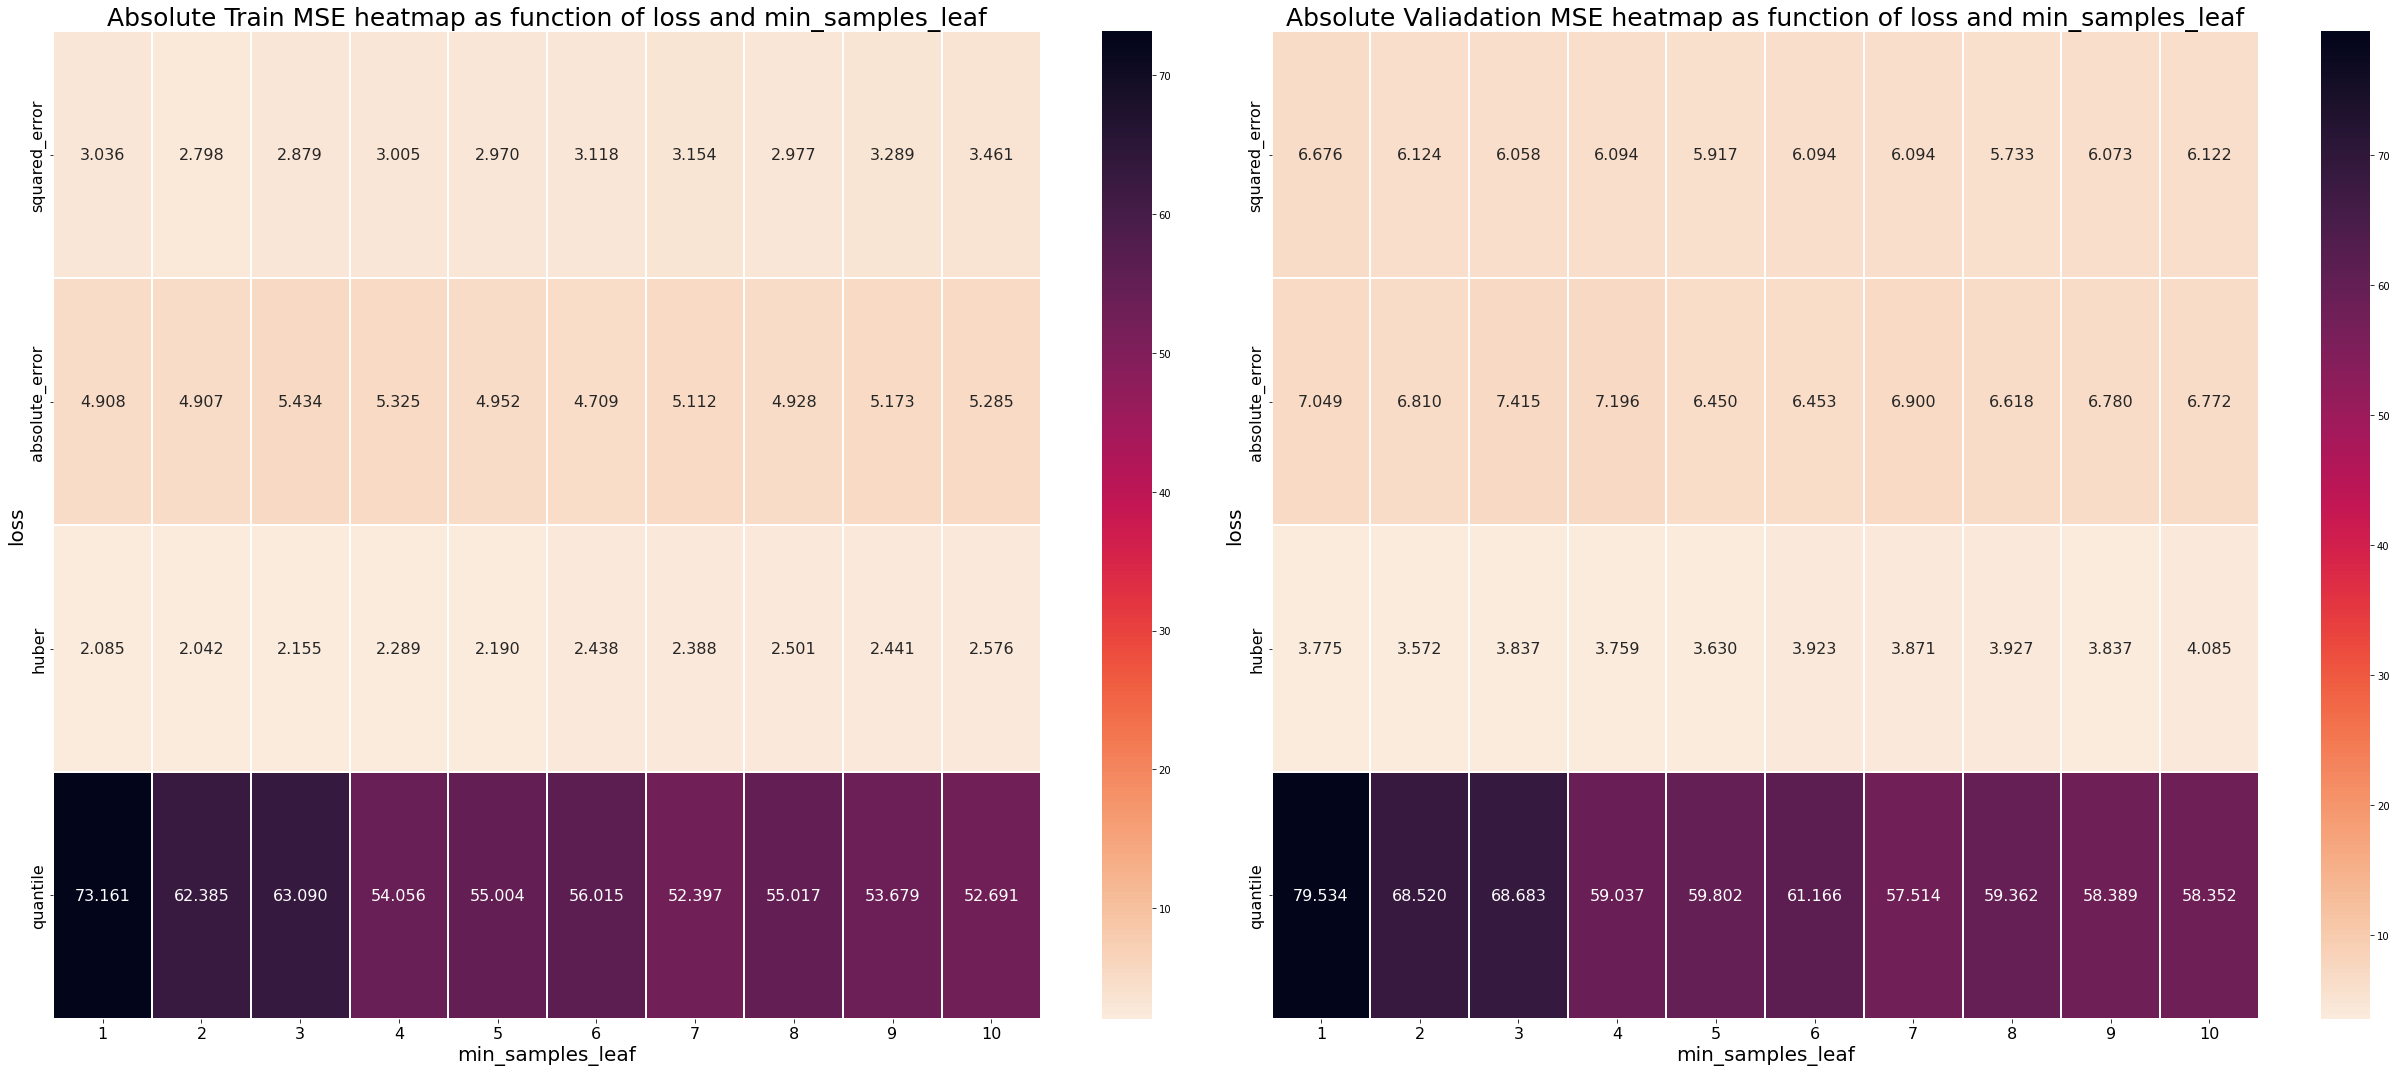

Best params: {'loss': 'huber', 'min_samples_leaf': 2}
Best validation score: 3.5724674673124204
Best validation score (confirm): 3.5724674673124204
Best train score: 2.0418323726957732


Const params: {'learning_rate': 0.1, 'min_samples_leaf': 2, 'random_state': 0}
iterable_paramse: {'loss': ['squared_error', 'absolute_error', 'huber', 'quantile'], 'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}


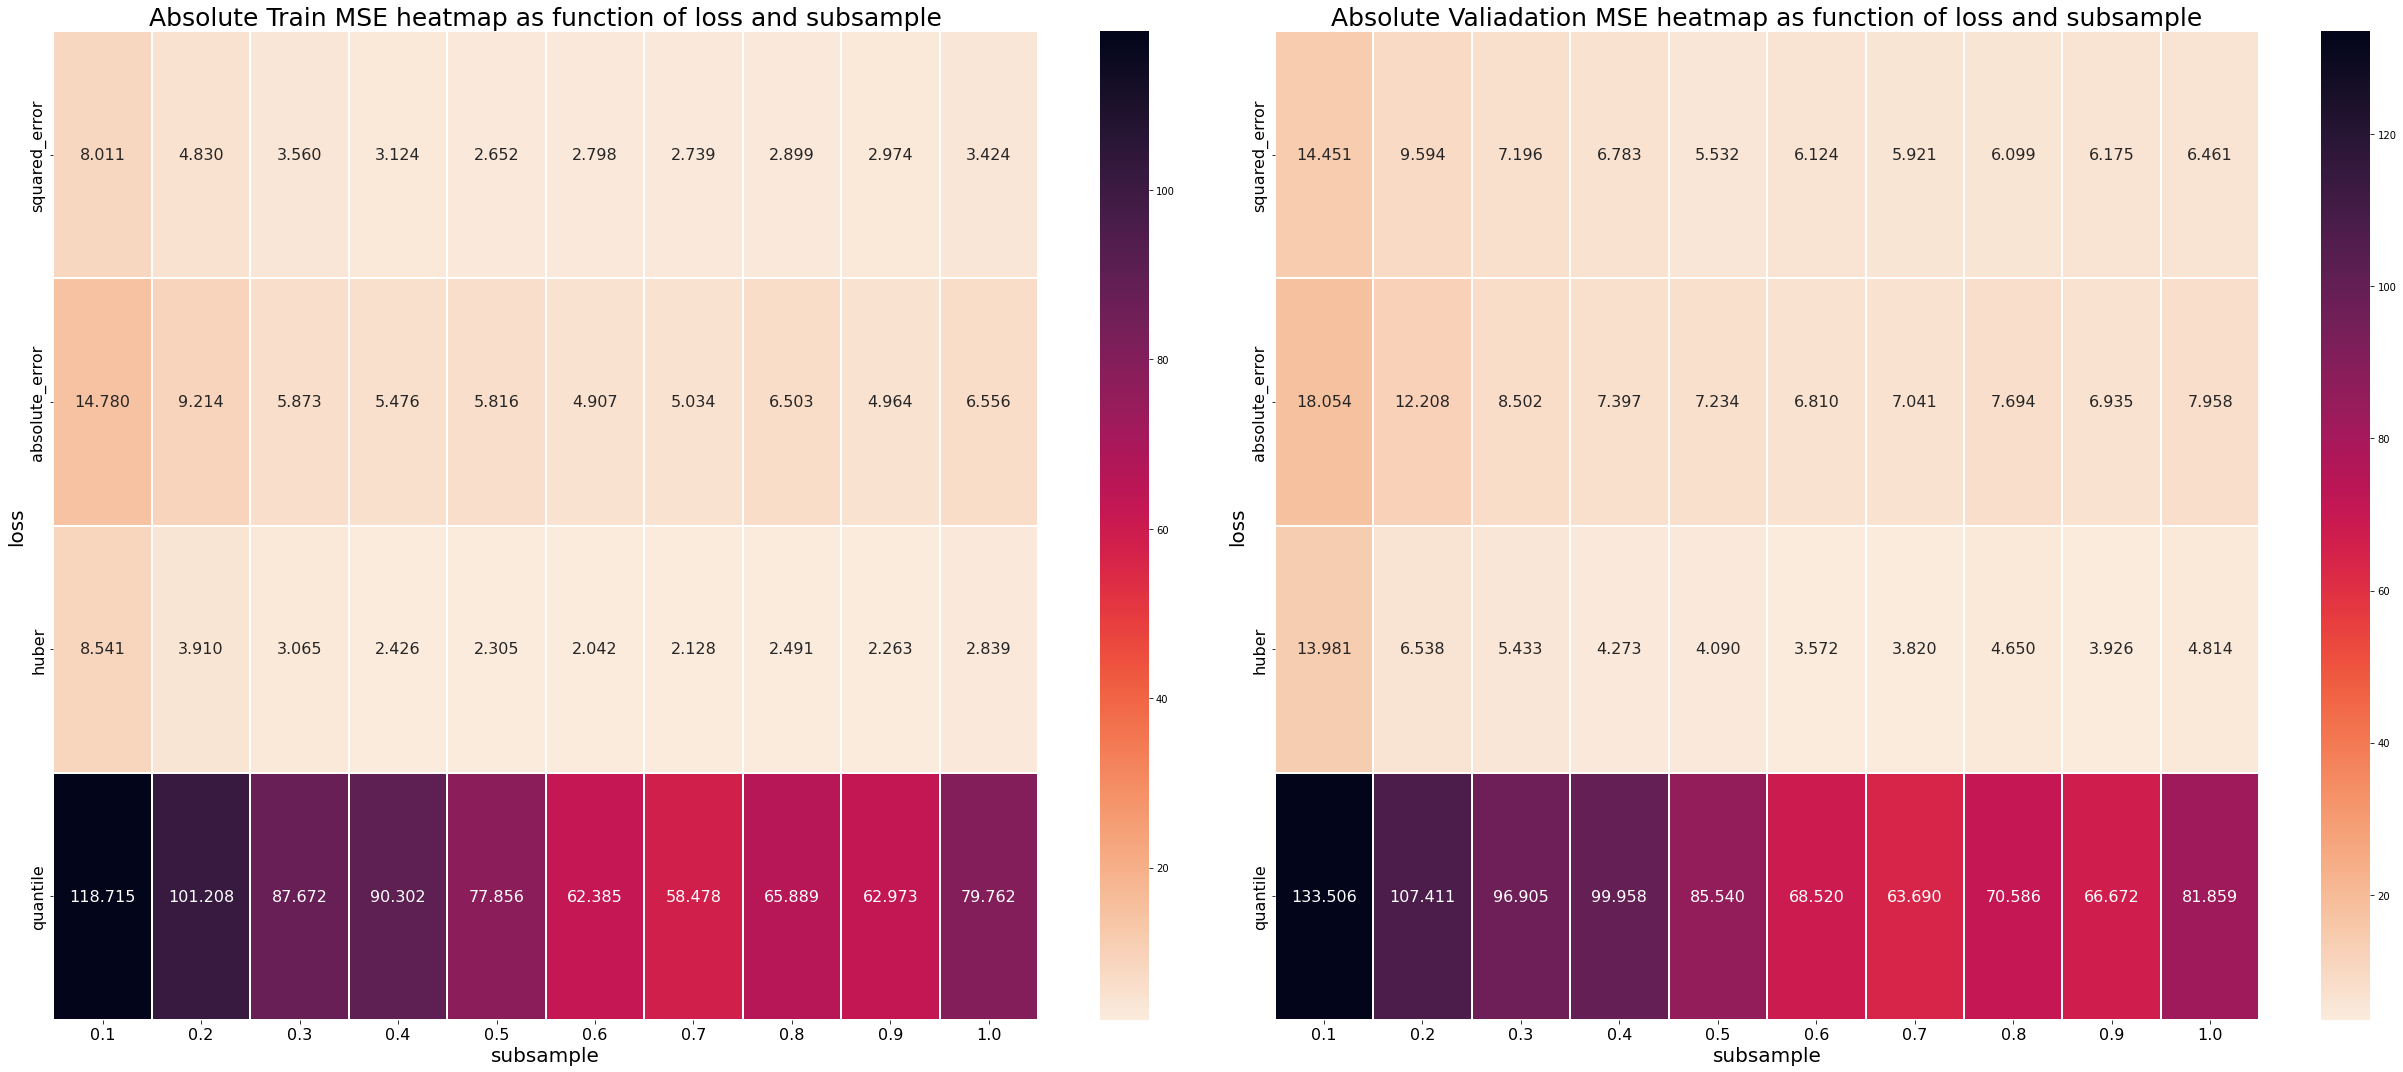

Best params: {'loss': 'huber', 'subsample': 0.6}
Best validation score: 3.5724674673124204
Best validation score (confirm): 3.5724674673124204
Best train score: 2.0418323726957732


Const params: {'subsample': 0.6, 'min_samples_leaf': 2, 'random_state': 0}
iterable_paramse: {'loss': ['squared_error', 'absolute_error', 'huber', 'quantile'], 'learning_rate': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1]}


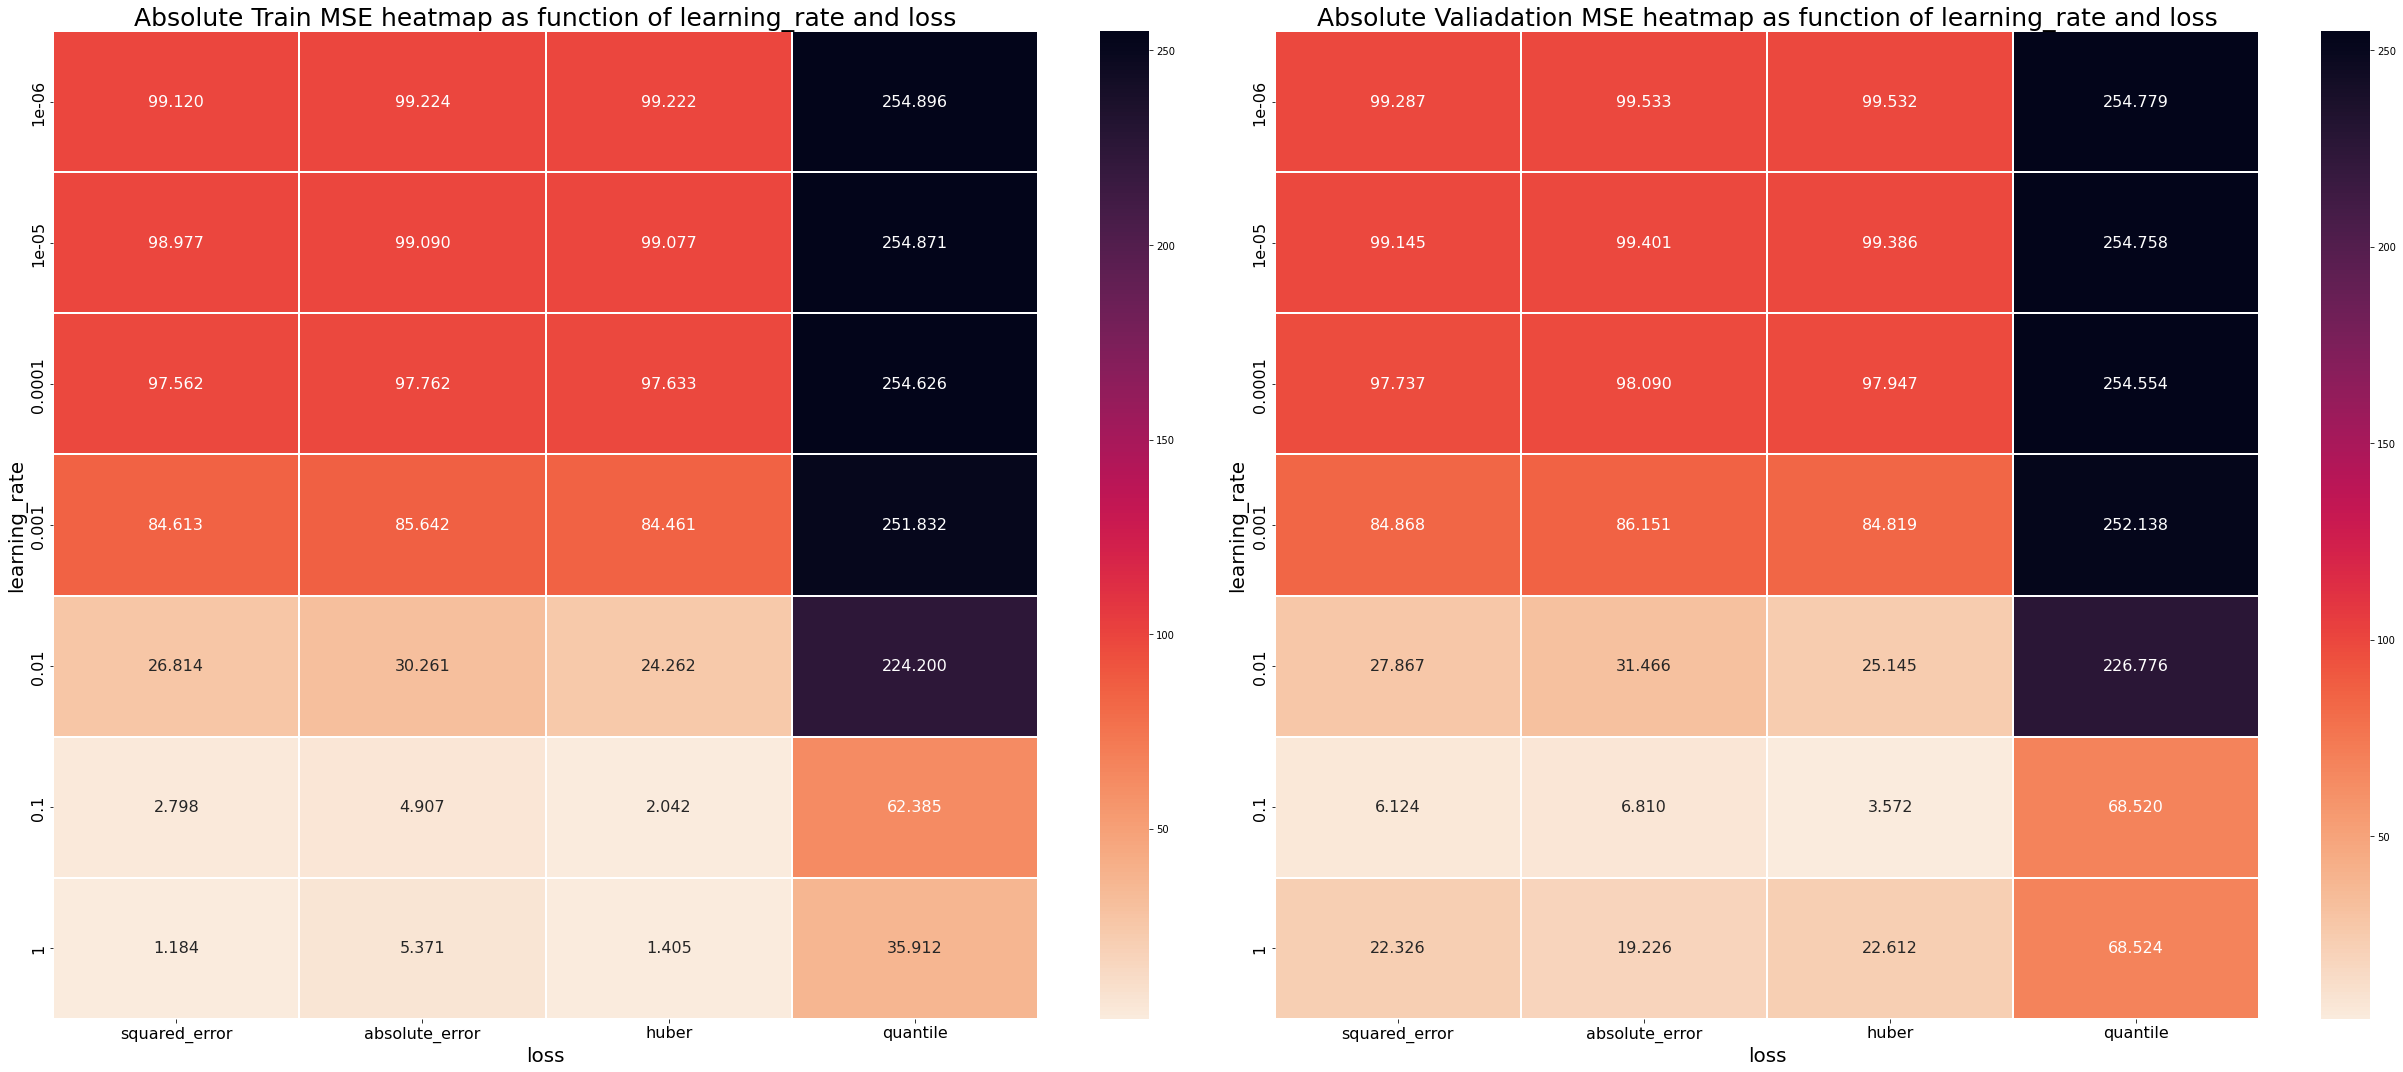

Best params: {'learning_rate': 0.1, 'loss': 'huber'}
Best validation score: 3.5724674673124204
Best validation score (confirm): 3.5724674673124204
Best train score: 2.0418323726957732




In [38]:
# best_params = {'learning_rate': 0.1, 'loss': 'huber', 'min_samples_leaf': 2, 'subsample': 0.6}
best_params = {'learning_rate': 0.1, 'loss': 'huber', 'min_samples_leaf': 2, 'subsample': 0.6}
hyper_param = {'loss':loss_values,'learning_rate':lr_values,'subsample':subsample_values,'min_samples_leaf':min_samples_leaf_values}
param_names = ['loss','learning_rate','subsample','min_samples_leaf']

for i in range(len(param_names)):
    for j in range(i+1,len(param_names),1):
        param1 = param_names[i]
        param2 = param_names[j]
        if param1 == param2:
            continue

        const_params = {}
        iterate_params = hyper_param.copy()
        del iterate_params[param1]
        del iterate_params[param2]
        const_params[param1] = best_params[param1]
        const_params[param2] = best_params[param2]
        const_params['random_state'] = 0

        print(f"Const params: {const_params}")
        print(f"iterable_paramse: {iterate_params}")
        gbr_gscv = GradientBoostingRegressor(**const_params)
        gscv_temp = GridSearchCV(estimator=gbr_gscv,param_grid=iterate_params,cv=FOLDS,scoring='neg_mean_squared_error', return_train_score=True)
        gscv_temp.fit(X_train_Sec_5,y_train)

        if (param1 == 'subsample' and param2 == 'min_samples_leaf') or (param1 == 'loss' and param2 == 'learning_rate'):
          key2,key1 = iterate_params.keys()
        else:
          key1,key2 = iterate_params.keys()

        validation_scores = np.abs(gscv_temp.cv_results_["mean_test_score"].reshape(len(iterate_params[key1]),len(iterate_params[key2])))
        train_scores = np.abs(gscv_temp.cv_results_["mean_train_score"].reshape(len(iterate_params[key1]),len(iterate_params[key2])))

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(35, 15))

        sns.heatmap(data=train_scores, annot=True, ax=ax1, fmt=".3f", linewidth=.4,cmap="rocket_r", annot_kws={"size": 16})
        ax1.set_title(f"Absolute Train MSE heatmap as function of {key1} and {key2}",fontsize=25)
        ax1.set_xlabel(f"{key2}",fontsize=20)
        ax1.set_ylabel(f"{key1}",fontsize=20)
        ax1.set_xticklabels(iterate_params[key2], fontsize=16)
        ax1.set_yticklabels(iterate_params[key1], fontsize=16)

        sns.heatmap(data=validation_scores, annot=True, ax=ax2, fmt=".3f", linewidth=.4,cmap="rocket_r", annot_kws={"size": 16})
        ax2.set_title(f"Absolute Valiadation MSE heatmap as function of {key1} and {key2}",fontsize=25)
        ax2.set_xlabel(f"{key2}",fontsize=20)
        ax2.set_ylabel(f"{key1}",fontsize=20)
        ax2.set_xticklabels(iterate_params[key2], fontsize=16)
        ax2.set_yticklabels(iterate_params[key1], fontsize=16)

        plt.tight_layout()
        plt.show()

        best_param = gscv_temp.best_params_
        best_train_score = abs(gscv_temp.cv_results_["mean_train_score"][gscv_temp.best_index_])
        best_val_score = abs(gscv_temp.cv_results_["mean_test_score"][gscv_temp.best_index_])
        print(f"Best params: {best_param}")
        print(f"Best validation score: {best_val_score}")
        print(f"Best validation score (confirm): {abs(gscv_temp.best_score_)}")
        print(f"Best train score: {best_train_score}")
        print()
        print()

#### Task

In [39]:
import copy
optimal_params = copy.deepcopy(best_params)
optimal_params['random_state'] = 0
optimal_gbr = GradientBoostingRegressor(**optimal_params)
optimal_gbr.fit(X_train_Sec_5,y_train)

GradientBoostingRegressor(loss='huber', min_samples_leaf=2, random_state=0,
                          subsample=0.6)

## Section 6: Testing your models

In [40]:
X_test= test.drop(columns= 'contamination_level')
y_test = test['contamination_level']
print(f"Dummy Test Score: {dummy_clf.score(X_test,y_test)}") 
print(f"Linear Regressor Test Score: {optimal_LinearReg.score(X_test,y_test)}")
print(f"Ridge Linear Regressor Test Score: {optimal_RidgeLinearRegressor.score(X_test,y_test)}")
#print(f"Gradient Boosting Regressor Test Score: {optimal_gbr.score(X_test,y_test)}")

Dummy Test Score: -1.6642234800468003e-05
Linear Regressor Test Score: 0.137044258744215
Ridge Linear Regressor Test Score: 0.13157640141680782
